<a href="https://colab.research.google.com/github/Misharosejoseph/Lip-reading-and-reconstruction-using-machine-learning/blob/main/LIP%20READING%20AND%20RECONSTRUCTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# installs (Colab usually already has tensorflow; installing TF can be slow — uncomment only if needed)
!pip install --quiet gdown imageio opencv-python pyttsx3 gTTS
!pip list | head -n 20


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.2 MB/s eta 0:00:00
Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
absolufy-imports                      0.3.1
accelerate                            1.10.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
alembic                               1.16.5
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
ERROR: Pipe to st

Import and cpu check


In [2]:
import os, sys, zipfile, shutil
import numpy as np
import cv2
import imageio
import tensorflow as tf
from matplotlib import pyplot as plt
from IPython.display import Audio, display

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Try enabling memory growth (safe)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
        print("Enabled memory growth for GPU(s).")
    except Exception as e:
        print("Could not set memory growth:", e)


TF version: 2.19.0
GPUs: []


Vocabulary and mapping


In [3]:
VOCAB = list("abcdefghijklmnopqrstuvwxyz0123456789'.,!?- ")
char_to_num = tf.keras.layers.StringLookup(vocabulary=VOCAB, mask_token=None)
num_to_char = tf.keras.layers.StringLookup(vocabulary=VOCAB, mask_token=None, invert=True)
print("vocab size:", char_to_num.vocabulary_size())


vocab size: 44


TRy download offical dataset


In [ ]:
import gdown, subprocess, time

DATA_DIR = "data"
S1_DIR = os.path.join(DATA_DIR, "s1")
ALIGN_DIR = os.path.join(DATA_DIR, "alignments", "s1")
os.makedirs(S1_DIR, exist_ok=True)
os.makedirs(ALIGN_DIR, exist_ok=True)

drive_url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
zip_name = 'data.zip'
success = False
print("Attempting to download dataset from report Drive link...")

try:
    gdown.download(drive_url, zip_name, quiet=False)
    # try to unzip
    if os.path.exists(zip_name):
        !unzip -o data.zip -d data
        success = True
except Exception as e:
    print("download failed:", e)

if not success:
    print("Could not download dataset — creating a small mock dataset for testing instead.")
    # create small mock dataset (2 videos, 2 alignments)
    import numpy as np, cv2
    for name in ["sample1.mpg", "sample2.mpg"]:
        path = os.path.join(S1_DIR, name)
        # create a small MPG-like video (75 frames, 140x46)
        fourcc = cv2.VideoWriter_fourcc(*"mpg1")
        out = cv2.VideoWriter(path, fourcc, 25, (140, 46))
        for _ in range(75):
            frame = np.random.randint(0, 256, (46, 140, 3), dtype=np.uint8)
            out.write(frame)
        out.release()
    for name in ["sample1.align", "sample2.align"]:
        with open(os.path.join(ALIGN_DIR, name), "w") as f:
            f.write("0 100 hello\n101 200 world\n")
    print("Mock dataset created at", S1_DIR)


Attempting to download dataset from report Drive link...


Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=11fdc92c-becf-415a-b636-2ab1491a448f
To: /content/data.zip
100%|██████████| 423M/423M [00:04<00:00, 87.1MB/s]


Archive:  data.zip
   creating: data/data/
   creating: data/data/alignments/
   creating: data/data/alignments/s1/
  inflating: data/data/alignments/s1/bbaf2n.align  
  inflating: data/data/alignments/s1/bbaf3s.align  
  inflating: data/data/alignments/s1/bbaf4p.align  
  inflating: data/data/alignments/s1/bbaf5a.align  
  inflating: data/data/alignments/s1/bbal6n.align  
  inflating: data/data/alignments/s1/bbal7s.align  
  inflating: data/data/alignments/s1/bbal8p.align  
  inflating: data/data/alignments/s1/bbal9a.align  
  inflating: data/data/alignments/s1/bbas1s.align  
  inflating: data/data/alignments/s1/bbas2p.align  
  inflating: data/data/alignments/s1/bbas3a.align  
  inflating: data/data/alignments/s1/bbaszn.align  
  inflating: data/data/alignments/s1/bbaz4n.align  
  inflating: data/data/alignments/s1/bbaz5s.align  
  inflating: data/data/alignments/s1/bbaz6p.align  
  inflating: data/data/alignments/s1/bbaz7a.align  
  inflating: data/data/alignments/s1/bbbf6n.align  


Loading data function

In [9]:
import os, sys, zipfile, shutil
import numpy as np
import cv2
import imageio
import tensorflow as tf
from matplotlib import pyplot as plt
from IPython.display import Audio, display

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Try enabling memory growth (safe)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
        print("Enabled memory growth for GPU(s).")
    except Exception as e:
        print("Could not set memory growth:", e)

def load_video(path: str):
    """Load video, crop ROI and normalize. Returns tf.Tensor shape (T,46,140,1)."""
    cap = cv2.VideoCapture(path)
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total <= 0: # Add this check
        print(f"Warning: Could not read video or it has no frames: {path}") # Add this warning
        return None # Return None if video cannot be read
    for _ in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        # convert BGR -> RGB -> grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        crop = gray[190:236, 80:220] if gray.shape[0] > 236 and gray.shape[1] > 220 else cv2.resize(gray, (140,46))
        frames.append(crop)
    cap.release()
    if len(frames) == 0:
        print(f"Warning: No frames read from {path} after opening.") # Add this warning
        return None # Return None if no frames were read
    arr = np.stack(frames).astype(np.float32)
    arr = (arr - arr.mean()) / (arr.std() + 1e-7)
    arr = arr[..., np.newaxis]  # (T,H,W,1)
    return tf.convert_to_tensor(arr, dtype=tf.float32)

def load_alignments(path: str):
    """Read .align file and return integer labels (char indices)."""
    tokens = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 3 and parts[2] != 'sil':
                tokens.append(' ' + parts[2])
    if len(tokens) == 0:
        tokens = [' ']
    txt = ''.join(tokens)
    chars = tf.strings.unicode_split(txt, input_encoding='UTF-8')
    return char_to_num(chars)

def load_data(path_tensor: tf.Tensor):
    """Wrapper usable with tf.py_function. Input: path tensor (string)."""
    path = path_tensor.numpy().decode('utf-8')
    file_name = os.path.basename(path).split('.')[0]
    video_path = os.path.join('data','data','s1', f'{file_name}.mpg') # Corrected path here too
    align_path = os.path.join('data','data','alignments','s1', f'{file_name}.align') # Corrected path here too
    frames = load_video(video_path)
    if frames is None: # Check if load_video returned None
        return None, None # Return None for both if video couldn't be loaded
    labels = load_alignments(align_path)
    return frames, labels

def mappable_function(path):
    frames, labels = tf.py_function(func=load_data, inp=[path], Tout=(tf.float32, tf.int64))
    # Add a filter step later to remove None values
    frames.set_shape([None, 46, 140, 1])
    labels.set_shape([None])
    return frames, labels

print("Data loader functions defined.")

TF version: 2.19.0
GPUs: []
Data loader functions defined.


Buld the pipeline

Found video files:
 - ./data/data/s1/pwwezn.mpg
 - ./data/data/s1/prwx6n.mpg
 - ./data/data/s1/sbit3s.mpg
 - ./data/data/s1/sgac4p.mpg
 - ./data/data/s1/prwx8p.mpg
 - ./data/data/s1/bgaa6n.mpg
 - ./data/data/s1/pgij9s.mpg
 - ./data/data/s1/pgay1s.mpg
 - ./data/data/s1/sgwp8n.mpg
 - ./data/data/s1/sgbp6p.mpg
 - ./data/data/s1/lbwk8n.mpg
 - ./data/data/s1/lwaz1s.mpg
 - ./data/data/s1/brbg5a.mpg
 - ./data/data/s1/pwad5a.mpg
 - ./data/data/s1/sban2n.mpg
 - ./data/data/s1/lrwf2p.mpg
 - ./data/data/s1/srbu6n.mpg
 - ./data/data/s1/lrbzzp.mpg
 - ./data/data/s1/lwae9s.mpg
 - ./data/data/s1/lwbs3a.mpg
 - ./data/data/s1/bbiz3a.mpg
 - ./data/data/s1/sbit4p.mpg
 - ./data/data/s1/srbb5s.mpg
 - ./data/data/s1/swao6p.mpg
 - ./data/data/s1/sbwb2n.mpg
 - ./data/data/s1/pbac3a.mpg
 - ./data/data/s1/lrbl2p.mpg
 - ./data/data/s1/sgii3s.mpg
 - ./data/data/s1/swab9a.mpg
 - ./data/data/s1/lrid8n.mpg
 - ./data/data/s1/bwat5a.mpg
 - ./data/data/s1/briz8p.mpg
 - ./data/data/s1/srih1s.mpg
 - ./data/data/s1/srbb7a

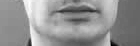

In [10]:
# list files (video paths)
files = tf.data.Dataset.list_files('./data/data/s1/*.mpg', shuffle=False)
print("Found video files:")
for f in tf.io.gfile.glob('./data/data/s1/*.mpg'):
    print(" -", f)

data = tf.data.Dataset.list_files('./data/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
# We pad time to 75 (report uses 75), spatial dims fixed at 46x140x1, labels padded variable
data = data.padded_batch(2, padded_shapes=([75,46,140,1],[None]))
data = data.prefetch(tf.data.AUTOTUNE)

# quick split (small demo)
train = data.take(1)
test = data.skip(1)

# inspect one batch
batch = next(iter(data))
print("Frames batch shape:", batch[0].shape)
print("Labels batch shape:", batch[1].shape)

# Save small GIF to inspect first video
example_frames = batch[0][0].numpy()  # (T,H,W,1)
# convert back to uint8 for gif (simple scaling)
gif_frames = [np.uint8(255*(f.squeeze()-f.min())/(f.max()-f.min()+1e-7)) for f in example_frames]
imageio.mimsave('sample_animation.gif', gif_frames, fps=10)
print("Saved sample_animation.gif")
try:
  from IPython.display import Image, display
  display(Image('sample_animation.gif'))
except ImportError:
  print("IPython.display.Image not available, cannot display GIF.")

Build model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

def build_model(input_shape=(75,46,140,1)):
    n_classes = char_to_num.vocabulary_size() + 1  # +1 for CTC blank
    model = Sequential()
    model.add(Conv3D(128, 3, padding='same', input_shape=input_shape)); model.add(Activation('relu')); model.add(MaxPool3D((1,2,2)))
    model.add(Conv3D(256, 3, padding='same')); model.add(Activation('relu')); model.add(MaxPool3D((1,2,2)))
    model.add(Conv3D(75, 3, padding='same'));  model.add(Activation('relu')); model.add(MaxPool3D((1,2,2)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer='orthogonal'))); model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer='orthogonal'))); model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer='he_normal'))
    return model

model = build_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 45)         │        11,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,472,952 (32.32 MB)

 Trainable params: 8,472,952 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

ctc loss,sheduler and example call back

In [12]:
def scheduler(epoch, lr):
    return lr if epoch < 30 else lr * tf.math.exp(-0.1)

def CTCLoss(y_true, y_pred):
    # y_true: (batch, label_len)
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        self.dataset = dataset.as_numpy_iterator()
    def on_epoch_end(self, epoch, logs=None):
        try:
            data = self.dataset.next()
        except StopIteration:
            return
        yhat = self.model.predict(data[0])
        # decode (greedy)
        decoded = tf.keras.backend.ctc_decode(yhat, input_length=[yhat.shape[1]]*yhat.shape[0], greedy=True)[0][0].numpy()
        for i in range(len(yhat)):
            true_text = tf.strings.reduce_join(num_to_char(data[1][i])).numpy().decode('utf-8')
            pred_text = tf.strings.reduce_join(num_to_char(decoded[i])).numpy().decode('utf-8')
            print(f"Original: {true_text}")
            print(f"Prediction: {pred_text}")
            print("-"*50)

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=CTCLoss)
print("Model compiled.")


Model compiled.


TRAIN A SHORT DEMO

In [17]:
# -------------------------
# Training - Short Demo
# -------------------------

# make sure models folder exists
os.makedirs('models', exist_ok=True)

# callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'models/checkpoint.weights.h5',
    monitor='loss',
    save_weights_only=True
)
lrcb = tf.keras.callbacks.LearningRateScheduler(scheduler)

# run only a few epochs on small data (fast mode)
history = model.fit(
    train.take(1),        # only 1 batch for quick demo
    validation_data=test.take(1),
    epochs=3,             # change to higher for real training
    callbacks=[checkpoint, lrcb]
)


Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 80s 80s/step - loss: 140.5920 - val_loss: 112.8736 - learning_rate: 1.0000e-04
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 70s 70s/step - loss: 121.8743 - val_loss: 97.2363 - learning_rate: 1.0000e-04
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 69s 69s/step - loss: 96.2299 - val_loss: 96.8645 - learning_rate: 1.0000e-04


 Try loading official checkpoint

In [18]:
ck_link = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
ck_zip = 'checkpoints.zip'
try:
    gdown.download(ck_link, ck_zip, quiet=False)
    !unzip -o checkpoints.zip -d models
    model.load_weights('models/checkpoint')
    print("Loaded official checkpoint.")
except Exception as e:
    print("Could not load official checkpoint; using current model weights:", e)


Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=f900e15d-9b19-4102-920b-9c055a0b4473
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 77.9MB/s]


Archive:  checkpoints.zip
  inflating: models/checkpoint.index  
  inflating: models/__MACOSX/._checkpoint.index  
  inflating: models/checkpoint.data-00000-of-00001  
  inflating: models/__MACOSX/._checkpoint.data-00000-of-00001  
  inflating: models/checkpoint       
  inflating: models/__MACOSX/._checkpoint  
Could not load official checkpoint; using current model weights: File format not supported: filepath=models/checkpoint. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.


 Prediction on a single video (and decoding)


Sample file: ./data/data/s1/bbaf2n.mpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction: [UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]


(np.float64(-0.5), np.float64(139.5), np.float64(45.5), np.float64(-0.5))

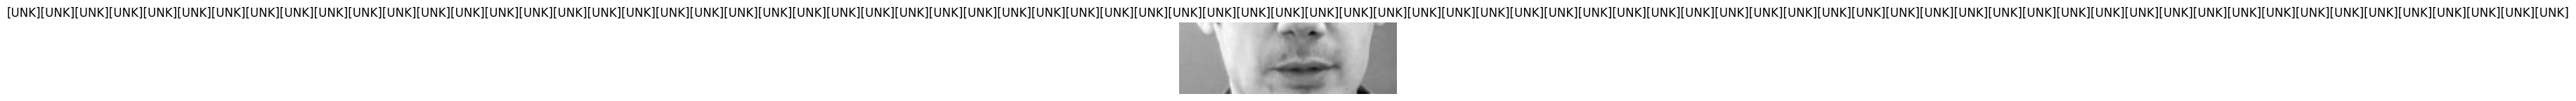

In [22]:
sample_file = sorted(tf.io.gfile.glob('./data/data/s1/*.mpg'))[0]
print("Sample file:", sample_file)
frames = load_video(sample_file)
yhat = model.predict(tf.expand_dims(frames, axis=0))  # (1, time, n_classes)
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[yhat.shape[1]], greedy=True)[0][0].numpy()

pred_text = tf.strings.reduce_join(num_to_char(decoded[0])).numpy().decode('utf-8')
print("Prediction:", pred_text)

# display a frame
plt.figure(figsize=(4,2))
plt.imshow(frames[10].numpy().squeeze(), cmap='gray')
plt.title(pred_text)
plt.axis('off')

Generate audio from predicted text

In [23]:
try:
    from gtts import gTTS
    tts = gTTS(text=pred_text or "hello", lang='en')
    tts.save('prediction.mp3')
    display(Audio('prediction.mp3', autoplay=False))
    print("Saved and displayed prediction.mp3")
except Exception as e:
    print("gTTS not available or failed:", e)
    # fallback: write text file
    with open('prediction.txt', 'w') as f:
        f.write(pred_text)
    print("Saved prediction text to prediction.txt")


Saved and displayed prediction.mp3


Export notebook as .ipynb or download model


In [25]:
model.save_weights('models/final_weights.weights.h5')

# To download weights you can zip
!zip -r model_weights.zip models
print("Created model_weights.zip - use the Colab Files pane to download.")

  adding: models/ (stored 0%)
  adding: models/checkpoint.index (deflated 72%)
  adding: models/final_weights.weights.h5 (deflated 8%)
  adding: models/__MACOSX/ (stored 0%)
  adding: models/__MACOSX/._checkpoint.data-00000-of-00001 (deflated 36%)
  adding: models/__MACOSX/._checkpoint (deflated 36%)
  adding: models/__MACOSX/._checkpoint.index (deflated 35%)
  adding: models/checkpoint (deflated 48%)
  adding: models/checkpoint.data-00000-of-00001 (deflated 7%)
  adding: models/checkpoint.weights.h5 (deflated 8%)
Created model_weights.zip - use the Colab Files pane to download.
